In [1]:
import numpy as np, pandas as pd
import json
from textblob import TextBlob
import nltk
import torch
import pickle
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
import spacy
from nltk import Tree
en_nlp = spacy.load('en')

In [2]:
# !conda update pandas --y

In [3]:
train = pd.read_csv("data/train.csv")

In [4]:
train.shape

(87599, 4)

### Loading Embedding dictionary

In [5]:
with open("data/dict_embeddings1.pickle", "rb") as f:
    d1 = pickle.load(f)

In [6]:
with open("data/dict_embeddings2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [7]:
dict_emb = dict(d1)
dict_emb.update(d2)

In [8]:
len(dict_emb)

179862

In [9]:
del d1, d2

## Data Processing

In [10]:
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if x["text"] in x["sentences"][i]: idx = i
    return idx

In [11]:
train.head(3)

,answer_start,context,question,text
0,515,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous
1,188,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,279,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building


In [12]:
train.shape

(87599, 4)

In [13]:
train.dropna(inplace=True)

In [14]:
train.shape

(87598, 4)

In [15]:
def process_data(train):
    
    print("step 1")
    train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
    
    print("step 2")
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3")
    train['sent_emb'] = train['sentences'].apply(lambda x: [dict_emb[item][0] if item in\
                                                           dict_emb else np.zeros(4096) for item in x])
    print("step 4")
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096) )
        
    return train   

In [16]:
train = process_data(train)

step 1
step 2
step 3
step 4


In [17]:
train.head(3)

,answer_start,context,question,text,sentences,target,sent_emb,quest_emb
0,515,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.055199966, 0.05013141, 0.047870383, 0.0162...","[[0.11010079, 0.11422941, 0.11560896, 0.054894..."
1,188,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.055199966, 0.05013141, 0.047870383, 0.0162...","[[0.10951651, 0.110306226, 0.052100066, 0.0305..."
2,279,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.055199966, 0.05013141, 0.047870383, 0.0162...","[[0.011956469, 0.14930707, 0.026600493, 0.0527..."


## Predicted Cosine & Euclidean Index

In [18]:
def cosine_sim(x):
    li = []
    for item in x["sent_emb"]:
        li.append(spatial.distance.cosine(item,x["quest_emb"][0]))
    return li   

In [19]:
def pred_idx(distances):
    return np.argmin(distances)   

In [20]:
def predictions(train):
    
    train["cosine_sim"] = train.apply(cosine_sim, axis = 1)
    train["diff"] = (train["quest_emb"] - train["sent_emb"])**2
    train["euclidean_dis"] = train["diff"].apply(lambda x: list(np.sum(x, axis = 1)))
    del train["diff"]
    
    print("cosine start")
    
    train["pred_idx_cos"] = train["cosine_sim"].apply(lambda x: pred_idx(x))
    train["pred_idx_euc"] = train["euclidean_dis"].apply(lambda x: pred_idx(x))
    
    return train
    

In [21]:
predicted = predictions(train)

In [22]:
predicted.head(3)

,answer_start,context,question,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,515,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.055199966, 0.05013141, 0.047870383, 0.0162...","[[0.11010079, 0.11422941, 0.11560896, 0.054894...","[0.424736299052452, 0.36405004106069117, 0.347...","[14.563858, 15.262212, 17.398178, 14.272491, 1...",5,5
1,188,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.055199966, 0.05013141, 0.047870383, 0.0162...","[[0.10951651, 0.110306226, 0.052100066, 0.0305...","[0.45407456884452513, 0.32262004808444933, 0.3...","[12.889506, 12.285219, 16.843704, 8.361172, 11...",3,3
2,279,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.055199966, 0.05013141, 0.047870383, 0.0162...","[[0.011956469, 0.14930707, 0.026600493, 0.0527...","[0.39585783692319865, 0.29170832145169434, 0.3...","[11.857297, 11.392319, 15.061656, 7.1847134, 8...",3,3


In [23]:
predicted["cosine_sim"][0]

[0.424736299052452,
 0.36405004106069117,
 0.3477550016687636,
 0.3942415731988862,
 0.37102476524939887,
 0.1856902254140269,
 0.35192069116776403]

In [24]:
predicted["euclidean_dis"][0]

[14.563858, 15.262212, 17.398178, 14.272491, 13.339654, 9.336262, 15.720997]

## Accuracy

In [25]:
def accuracy(target, predicted):
    
    acc = (target==predicted).sum()/len(target)
    
    return acc

### Accuracy for  euclidean Distance

In [26]:
print(accuracy(predicted["target"], predicted["pred_idx_euc"]))

0.44856046941711


### Accuracy for Cosine Similarity

In [27]:
print(accuracy(predicted["target"], predicted["pred_idx_cos"]))

0.6338843352587958


In [44]:
predicted.to_csv("train_detect_sent.csv", index=None)

In [34]:
predicted.iloc[75207,:]

answer_start                                                    69
context          Both the vertical and dipole antennas are simp...
question                             Are basic antennas expensive?
text                                        relatively inexpensive
sentences        [Both the vertical and dipole antennas are sim...
target                                                           0
sent_emb         [[0.06494937, 0.03690031, 0.12519251, -0.02735...
quest_emb        [[0.031715073, 0.07947657, 0.030824697, 0.0126...
cosine_sim       [0.359188584685867, 0.4689117244223153, 0.4489...
euclidean_dis    [11.512397, 21.817242, 12.696278, 17.895185, 1...
pred_idx_cos                                                     0
pred_idx_euc                                                     0
Name: 75208, dtype: object

In [38]:
ct,k = 0,0
for i in range(predicted.shape[0]):
    if predicted.iloc[i,10] != predicted.iloc[i,5]:
        k += 1
        if predicted.iloc[i,11] == predicted.iloc[i,5]:
            ct += 1

In [39]:
ct, k

(5545, 32071)

### Combining Accuracy

In [47]:
label = []
for i in range(predicted.shape[0]):
    if predicted.iloc[i,10] == predicted.iloc[i,11]:
        label.append(predicted.iloc[i,10])
    else:
        label.append((predicted.iloc[i,10],predicted.iloc[i,10]))

In [66]:
ct = 0
for i in range(75206):
    item = predicted["target"][i]
    try:
        if label[i] == predicted["target"][i]: ct +=1
    except:
        if item in label[i]: ct +=1
            

In [68]:
ct/75206

0.6370901257878361

### Root Match

In [8]:
predicted = pd.read_csv("train_detect_sent.csv").reset_index(drop=True)

In [9]:
doc = en_nlp(predicted.iloc[0,1])

In [27]:
predicted.iloc[0,1]

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [4]:
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

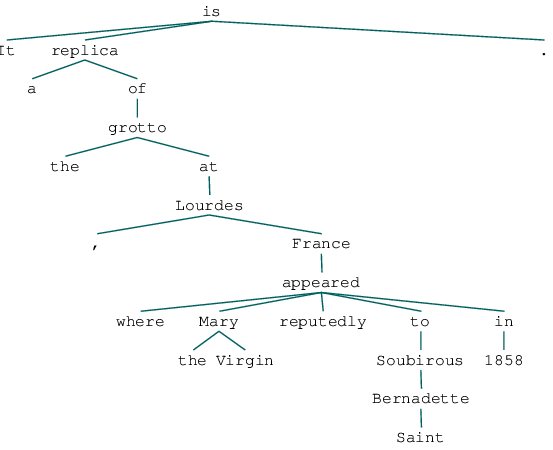

In [25]:
[to_nltk_tree(sent.root) for sent in doc.sents][5]

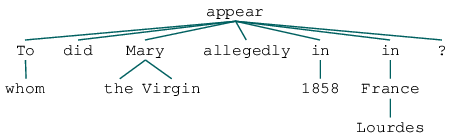

In [23]:
[to_nltk_tree(sent.root) for sent in en_nlp(predicted.iloc[0,2]).sents][0]